In [269]:
import os
import sys
import random
import json

import csv
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from anytree.exporter import JsonExporter

import networkx as nx
import xml.etree.ElementTree as ET


import numpy as np
import pandas as pd
import ast

from matplotlib.collections import LineCollection  # noqa
from matplotlib import colors as mcolors
from matplotlib.patches import FancyArrowPatch

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

import sumolib

import matplotlib.pyplot as plt
%matplotlib notebook

In [270]:
ColorLS = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
           (1.0, 0.4980392156862745, 0.054901960784313725), \
           (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),\
           (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
           (0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
           (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),\
           (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
           (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), \
           (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), \
           (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


In [271]:
net = sumolib.net.readNet('./NashNet/large.net.xml')
AllEdgeList = net.getEdges()
AllEdgeIDList = [edge.getID() for edge in net.getEdges()]

CBD_net = sumolib.net.readNet('./NashNet/CBD.net.xml')
CBDEdgeList = CBD_net.getEdges()
CBDEdgeIDList = [edge.getID() for edge in CBD_net.getEdges()]

In [272]:
### get exiting edge ls
CBD_signals = [node for node in CBD_net.getNodes()]
CBD_boundary_nodes = [TL for TL in CBD_signals if len(TL.getConnections())!=12]

CBD_bound_node_IDs = [no.getID() for no in CBD_boundary_nodes]


exit_edges = []
for node in CBD_boundary_nodes:
    for edge in node.getIncoming():
        exit_edges.append(edge.getID())

## Give density level and the episode number

In [273]:
def GetArrivalDeparture_episode(Policy,epi,demand_mean,loading_rate):
    #### process the edge data 
    edge_output = './NashNet/FullEdgeData_{}_demand_{}_loading_{}_epi{}.xml'.format\
    (Policy,demand_mean,loading_rate, epi)
    mytree = ET.parse(edge_output)
    root = mytree.getroot()
    Interval_ls = [IntervalData for IntervalData in root]

    arrival_hist = []
    departure_hist = []
    exiting_hist = []
    for i in range(len(Interval_ls)):
        EdgeData_ls = [IntervalData.attrib for IntervalData in Interval_ls[i]]
        interval_df = pd.DataFrame.from_dict(EdgeData_ls)
        interval_df['arrived'] = interval_df['arrived'].astype(float)
        interval_df['departed'] = interval_df['departed'].astype(float)
        interval_df['left'] = interval_df['left'].astype(float)
        arrival_hist.append(np.sum(interval_df['arrived']))
        departure_hist.append(np.sum(interval_df['departed']))    
        exiting_hist.append(np.sum(interval_df[interval_df['id'].isin(exit_edges)]['left']))    

    return arrival_hist, departure_hist, exiting_hist

In [274]:
def Get_df_from_Edge(Policy,epi,demand_mean,loading_rate):
    #### process the edge data 
    edge_output = './NashNet/FullEdgeData_{}_demand_{}_loading_{}_epi{}.xml'.format\
    (Policy,demand_mean,loading_rate, epi)
    mytree = ET.parse(edge_output)
    root = mytree.getroot()
    Interval_ls = [IntervalData for IntervalData in root]
    return Interval_ls

In [275]:
def Get_interval_df_from_ls(Interval_ls, select_index):
    select_interval = Interval_ls[select_index]
    EdgeData_ls = [IntervalData.attrib for IntervalData in select_interval]
    interval_df = pd.DataFrame.from_dict(EdgeData_ls)
#     interval_df = interval_df[interval_df['id'].isin(CBDEdgeIDList)]
    interval_df['density'] = interval_df['density'].astype(float)
    interval_df['k'] = interval_df['density']/150.0
    interval_df['speed'] = interval_df['speed'].astype(float)
    interval_df['flow'] = np.round(interval_df['density']*interval_df['speed']*3.6,1)  
    interval_df['v'] = interval_df['speed']/14.0
    
    return interval_df

In [322]:
Policy = 'Regular'
demand_mean = 20
lr = 60 # 1, 30, 60, 180, 300, 480, 600
epi = 0
select_index = 13

In [323]:
Interval_ls = Get_df_from_Edge(Policy,epi,demand_mean,lr)
interval_df = Get_interval_df_from_ls(Interval_ls, select_index)

## Here we define criteria for percolation

<IPython.core.display.Javascript object>


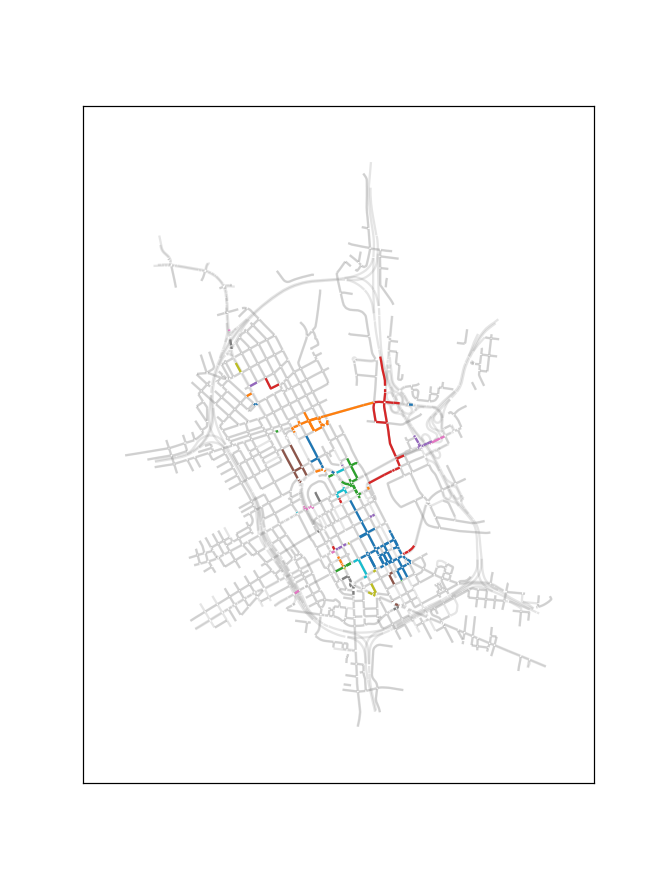

[]

In [324]:
crit_value = 0.4

percolating_edge_ls = interval_df[interval_df['k'] > crit_value]['id'].tolist() 
PercoEdgeList = [net.getEdge(edge_name) for edge_name in percolating_edge_ls]

### -------- cluster those connected links --------------
N = len(PercoEdgeList)
# Create an empty graph
graph = nx.Graph()
# Add nodes for each link in the list
links = [edge.getID() for edge in PercoEdgeList]
graph.add_nodes_from(links)
# Add connectivity between links
topology = []
if N >=1:
    for i_index in range(N):
        for j_index in range(i_index+1,N):
            i = PercoEdgeList[i_index]
            j = PercoEdgeList[j_index]
            if i in j.getOutgoing():
                topology.append((i.getID(),j.getID()))
            if i in j.getIncoming():
                topology.append((j.getID(),i.getID()))        

graph.add_edges_from(topology)

# Apply the Connected Components algorithm to identify clusters
clusters = list(nx.connected_components(graph))
# clusters = [cluster for cluster in clusters if len(cluster)>2]
### now let's rank the cluster by size
clusters.sort(key=lambda x: len(x), reverse=True)

fig, (ax1) = plt.subplots(1,1, figsize=(6,8))
shapes = []
for e in AllEdgeList:
    shapes.append(e.getShape())
line_segments = LineCollection(shapes,colors = [(0.5, 0.5, 0.5, 0.2)])
ax1.add_collection(line_segments)



#### plot the percolating links only
percolating_points = []
index = 0
for cluster in clusters:
    shapes = []
    for edge_name in cluster:
        shapes.append(net.getEdge(edge_name).getShape())
        percolating_points.append(net.getEdge(edge_name).getFromNode().getCoord())
        percolating_points.append(net.getEdge(edge_name).getToNode().getCoord())
    line_segments = LineCollection(shapes,colors = ColorLS[index%len(ColorLS)],linewidths=1.5)
    ax1.add_collection(line_segments)
    index+=1

ax1.set_xmargin(0.1)
ax1.set_ymargin(0.1)
# ax1.set_title('percolating clusters at interval {} with k > {}'.format(select_index,den_threshold))

ax1.set_xticks([])
# Hide the ticks on the y-axis
ax1.set_yticks([])


## draw the CDB boundary lines